# Final Project

In [29]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import csv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Read file
mg = pd.read_csv("music_genre.csv")


# Remove duplicate rows from the DataFrame
mg = mg.drop_duplicates(keep=False)

mg.reset_index(inplace=True)

# Drop any rows that contain NA
# mg = mg.dropna()

mg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             50000 non-null  int64  
 1   instance_id       50000 non-null  float64
 2   artist_name       50000 non-null  object 
 3   track_name        50000 non-null  object 
 4   popularity        50000 non-null  float64
 5   acousticness      50000 non-null  float64
 6   danceability      50000 non-null  float64
 7   duration_ms       50000 non-null  float64
 8   energy            50000 non-null  float64
 9   instrumentalness  50000 non-null  float64
 10  key               50000 non-null  object 
 11  liveness          50000 non-null  float64
 12  loudness          50000 non-null  float64
 13  mode              50000 non-null  object 
 14  speechiness       50000 non-null  float64
 15  tempo             50000 non-null  object 
 16  obtained_date     50000 non-null  object

In [9]:
### Creating a variable for the music genres to be plotted
class_names=sorted(mg['music_genre'].unique().tolist())
print(class_names)

['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']


In [10]:
### Check to see how many enteries are there for each class
class_counts = mg['music_genre'].value_counts()
class_counts

music_genre
Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: count, dtype: int64

In [11]:
### Using label encoder for the music genres
mg['music_genre'] = LabelEncoder().fit_transform(mg['music_genre'])

In [12]:
### Feature Engineering to manipulate data 

# Previously had a problem with certain parts of my code due to the '?' variables in my column of 'Tempo' so changing '?' to 'nan' for imputation process
mg['tempo'] = mg['tempo'].replace('?', np.nan).astype(np.float64)



# Adding label encoding to 'key' column 
mg['key'] = LabelEncoder().fit_transform(mg['key'])

# Adding feature engineering to 'key' column 
mg['Major'] = mg['mode'].apply(lambda x: 1 if 'Major' in x else 0)
mg['Minor'] = mg['mode'].apply(lambda x: 1 if 'Minor' in x else 0)



# Changing the 'duration_ms' column so that we could replace all '-1' to 'nan'
mg['duration_ms'] = mg['duration_ms'].replace(-1, np.nan)



genres = sorted(list(pd.unique(mg["music_genre"])))

# Analyzing the track name to see if there are any patterns
def Elements_of_Track_Name(element: str) -> pd.Series:
    print("Number of songs in each group including '{}' in track_name:".format(element))
    # Check if the substring is present in the track_name column
    contains_element = mg['track_name'].str.contains(element, case=False)
    # Display the count of True values (songs containing the substring) for each music genre
    display(mg.loc[contains_element, 'music_genre'].value_counts())

# Adding number of ':' in dataframe to classify classical music
for element in [':']:
    mg["{} in track name".format(element)] = [0] * len(mg)

    # A new column named "{} in track name" is added to the DataFrame `df` with all values initialized to 0.

    for i in range(len(mg)):
        if element in mg['track_name'][i]:
            mg["{} in track name".format(element)][i] = 1

# These are just warnings. I believe it works fine as I checked that the dataframe contains a boolean of whether ':' exists in the track name or not

/var/folders/d4/krqggn9s3bx3xdmk_bk_0z6m0000gn/T/ipykernel_11947/1163466038.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg["{} in track name".format(element)][i] = 1
/var/folders/d4/krqggn9s3bx3xdmk_bk_0z6m0000gn/T/ipykernel_11947/1163466038.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg["{} in track name".format(element)][i] = 1
/var/folders/d4/krqggn9s3bx3xdmk_bk_0z6m0000gn/T/ipykernel_11947/1163466038.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [13]:
Elements_of_Track_Name(':')

Number of songs in each group including ':' in track_name:


music_genre
3    3105
1      75
7      18
5      15
2      14
8      11
6      10
0       8
4       6
9       5
Name: count, dtype: int64

In [14]:
### Splitting data into train and test

train, test = train_test_split(mg, test_size=0.2, random_state=7)

train_y = train['music_genre']
test_y = test['music_genre']
train_X = train.drop(columns = ['index', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'mode', 'music_genre'])
test_X = test.drop(columns = ['index', 'instance_id', 'artist_name', 'track_name', 'obtained_date', 'mode', 'music_genre'])

# Record the current columns after dropping the features.
names = train_X.columns

# Create a new DataFrame by applying KNNImputer to impute missing values, and assign the column names.
train_X = pd.DataFrame(KNNImputer().fit_transform(train_X), columns=names)
test_X = pd.DataFrame(KNNImputer().fit_transform(test_X), columns=names)

        popularity  acousticness  danceability   duration_ms        energy  \
count  40000.00000  40000.000000  40000.000000  4.000000e+04  40000.000000   
mean      44.22775      0.306046      0.557844  2.456046e+05      0.600464   
std       15.55411      0.341381      0.178697  1.061956e+05      0.264311   
min        0.00000      0.000000      0.059600  1.550900e+04      0.000792   
25%       34.00000      0.019600      0.442000  1.938152e+05      0.434000   
50%       45.00000      0.144000      0.567000  2.287273e+05      0.644000   
75%       56.00000      0.552000      0.687000  2.742878e+05      0.816000   
max       99.00000      0.996000      0.986000  4.830606e+06      0.999000   

       instrumentalness           key      liveness      loudness  \
count      40000.000000  40000.000000  40000.000000  40000.000000   
mean           0.182107      5.352275      0.193850     -9.119255   
std            0.325638      3.455080      0.161674      6.154525   
min            0.0000

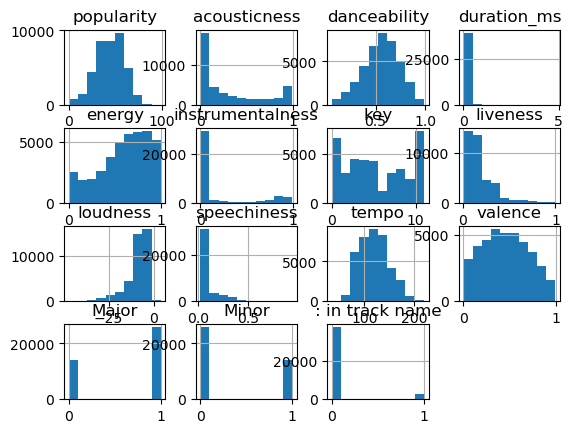

In [15]:
## Descriptive stats
print(train_X.describe())

## Distributions
train_X.hist()
plt.show()

In [16]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        40000 non-null  float64
 1   acousticness      40000 non-null  float64
 2   danceability      40000 non-null  float64
 3   duration_ms       40000 non-null  float64
 4   energy            40000 non-null  float64
 5   instrumentalness  40000 non-null  float64
 6   key               40000 non-null  float64
 7   liveness          40000 non-null  float64
 8   loudness          40000 non-null  float64
 9   speechiness       40000 non-null  float64
 10  tempo             40000 non-null  float64
 11  valence           40000 non-null  float64
 12  Major             40000 non-null  float64
 13  Minor             40000 non-null  float64
 14  : in track name   40000 non-null  float64
dtypes: float64(15)
memory usage: 4.6 MB


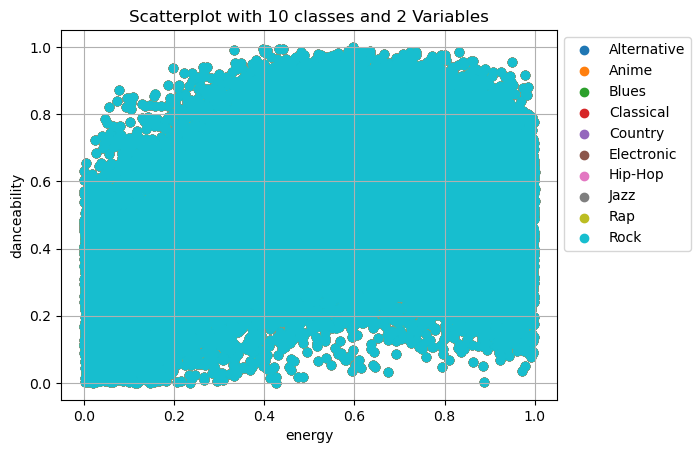

In [38]:
# Fit MinMaxScaler to train_X and transform train_X
train_Xs = MinMaxScaler().fit_transform(train_X)

train_Xs_mg = pd.DataFrame(train_Xs, columns=train_X.columns)

for i in range(len(class_names)):
    plt.scatter(train_Xs_mg['energy'], train_Xs_mg['danceability'], label=class_names[i])

plt.xlabel('energy')
plt.ylabel('danceability')
plt.title('Scatterplot with 10 classes and 2 Variables')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### KNN Model

In [18]:
### Testing KNN model

pipe = Pipeline([
        ('preprocessing', StandardScaler()), 
        ('transformer',  PowerTransformer(method = 'yeo-johnson')),
        ('knn', KNeighborsClassifier())
])
param = {'preprocessing': [StandardScaler(), MinMaxScaler()],
        'knn__n_neighbors': [10, 20, 30, 40, 50, 60],  
        'knn__weights': ['uniform', 'distance']}

grid_search = GridSearchCV(pipe, param, cv=5, scoring='f1_macro').fit(train_X, train_y)
print(grid_search.best_params_)
grid_search.best_score_

{'knn__n_neighbors': 50, 'knn__weights': 'uniform', 'preprocessing': MinMaxScaler()}


0.5265383773007376

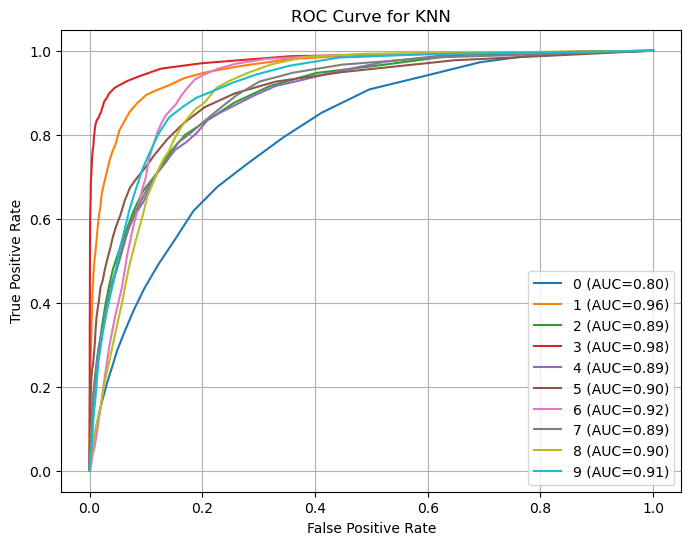

In [19]:
### Plotting ROC Curve of KNN model

y_pred = grid_search.predict(test_X)
y_scores = grid_search.predict_proba(test_X)
    
# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(test_y)

# Create ROC Curve plot
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"{genres[i]} (AUC={auc_score:.2f})")

# Update layout and display ROC Curve plot
plt.title("ROC Curve for KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

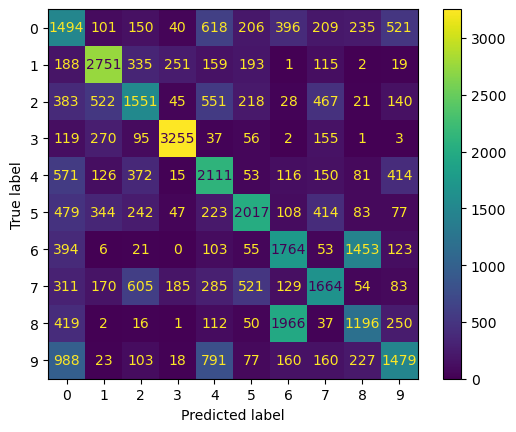

In [27]:
### Confusion Matrix for KNN model

train_y_pred = cross_val_predict(estimator = pipe, X = train_X, y = train_y, cv = 5)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = train_y, y_pred = train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_y, train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

### XGBoost Model

In [34]:
### Testing XGBoost Model

pipe2 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('xgb', xgb.XGBClassifier(learning_rate = 0.01))
])
param2 = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 3, 5]
}

grid_search2 = GridSearchCV(pipe2, param2, cv=5, scoring='f1_macro').fit(train_X, train_y)
print(grid_search2.best_params_)
grid_search2.best_score_

{'xgb__max_depth': 7, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 300}


0.5808544262352711

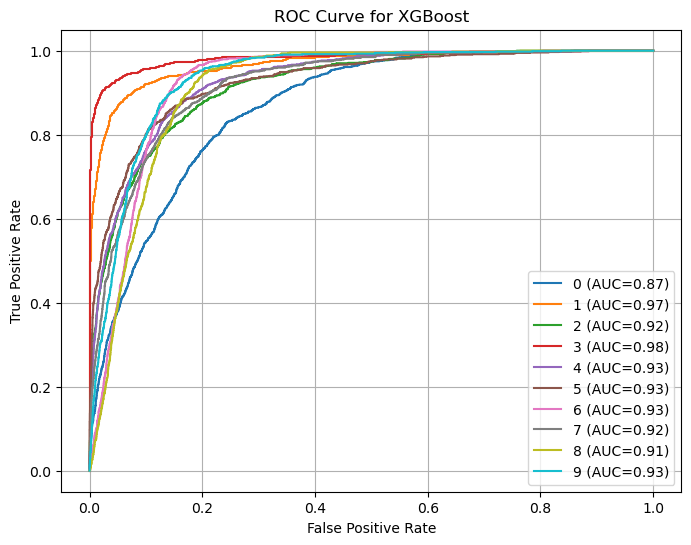

In [35]:
### Plotting ROC Curve of XGBoost model

y_pred = grid_search2.predict(test_X)
y_scores = grid_search2.predict_proba(test_X)
    
# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(test_y)

# Create ROC Curve plot
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"{genres[i]} (AUC={auc_score:.2f})")

# Update layout and display ROC Curve plot
plt.title("ROC Curve for XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

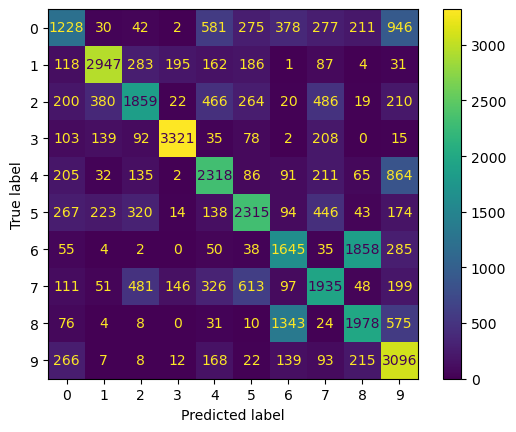

In [36]:
### Confusion Matrix for XGBoost model

train_y_pred = cross_val_predict(estimator = pipe2, X = train_X, y = train_y, cv = 5)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = train_y, y_pred = train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_y, train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

### Light Gradient Boosting Model (LGBM)

In [40]:
### Testing Light GBM Model
pipe3 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('lgbm', lgb.LGBMClassifier())
])
param3 = {"lgbm__learning_rate": [0.001, 0.01, 0.1],
          "lgbm__n_estimators": [30, 100, 300],
          "lgbm__colsample_bytree": [0.3, 0.5, 0.7]}
grid_search3 = GridSearchCV(pipe3, param3, cv=5, scoring='f1_macro').fit(train_X, train_y)
print(grid_search3.best_params_)
grid_search3.best_score_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 15
[LightGBM] [Info] Start training from score -2.310113
[LightGBM] [Info] Start training from score -2.299153
[LightGBM] [Info] Start training from score -2.321195
[LightGBM] [Info] Start training from score -2.304149
[LightGBM] [Info] Start training from score -2.300400
[LightGBM] [Info] Start training from score -2.294183
[LightGBM] [Info] Start training from score -2.309799
[LightGBM] [Info] Start training from score -2.300712
[LightGBM] [Info] Start training from score -2.290471
[LightGBM] [Info] Start training from score -2.296044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You

0.5910264315589083

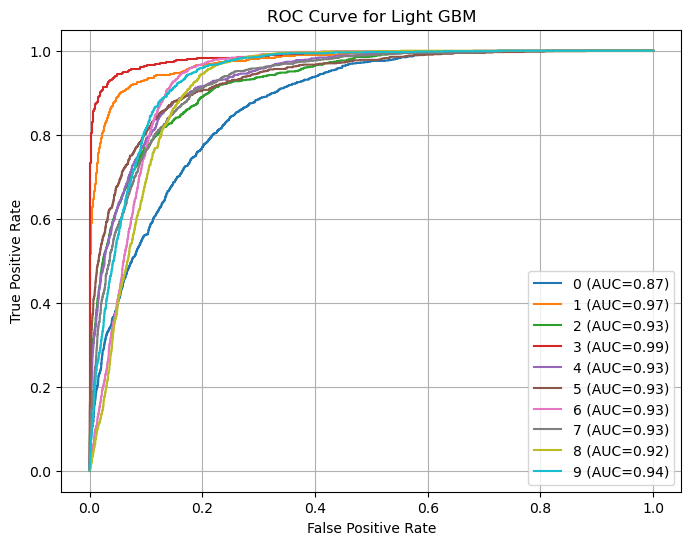

In [23]:
### Plotting ROC Curve of LGBM model

y_pred = grid_search3.predict(test_X)
y_scores = grid_search3.predict_proba(test_X)
    
# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(test_y)

# Create ROC Curve plot
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"{genres[i]} (AUC={auc_score:.2f})")

# Update layout and display ROC Curve plot
plt.title("ROC Curve for Light GBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 15
[LightGBM] [Info] Start training from score -2.310113
[LightGBM] [Info] Start training from score -2.299153
[LightGBM] [Info] Start training from score -2.321195
[LightGBM] [Info] Start training from score -2.304149
[LightGBM] [Info] Start training from score -2.300400
[LightGBM] [Info] Start training from score -2.294183
[LightGBM] [Info] Start training from score -2.309799
[LightGBM] [Info] Start training from score -2.300712
[LightGBM] [Info] Start training from score -2.290471
[LightGBM] [Info] Start training from score -2.296044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You

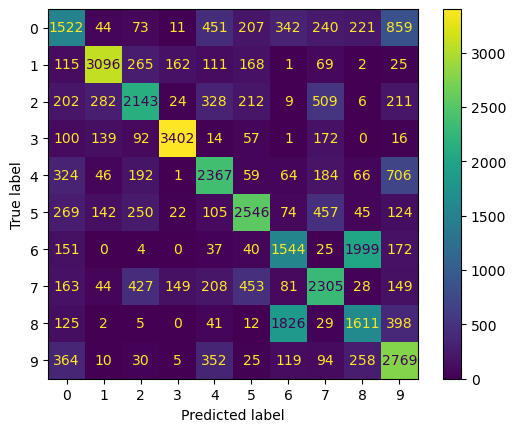

In [28]:
### Confusion Matrix for Light GBM model

train_y_pred = cross_val_predict(estimator = pipe3, X = train_X, y = train_y, cv = 5)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = train_y, y_pred = train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_y, train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

### Random Forest Classifier Model

In [30]:
### Testing Random Forest Classifier Model
pipe4 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rf', RandomForestClassifier())
])

# Define parameters for tuning
param4 = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search4 = GridSearchCV(pipe4, param4, cv=5, scoring='f1_macro').fit(train_X, train_y)
print(grid_search4.best_params_)
grid_search4.best_score_

{'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


0.5674902190150288

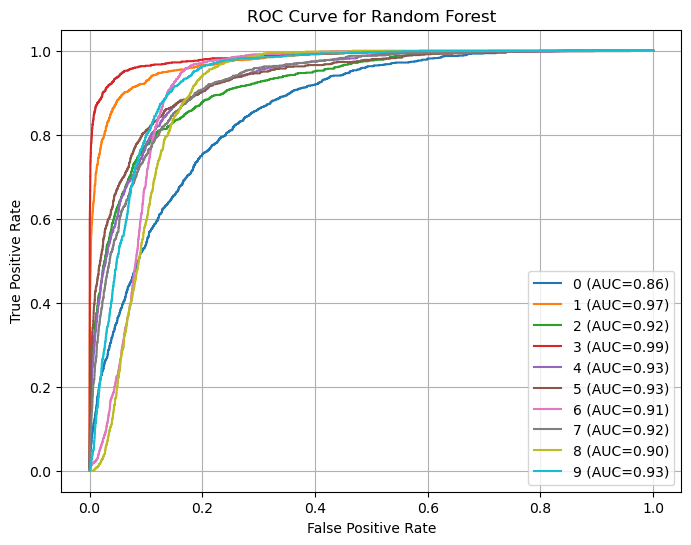

In [39]:
### Plotting ROC Curve of Random Forest Classifier model

y_pred = grid_search4.predict(test_X)
y_scores = grid_search4.predict_proba(test_X)
    
# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(test_y)

# Create ROC Curve plot
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f"{genres[i]} (AUC={auc_score:.2f})")

# Update layout and display ROC Curve plot
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

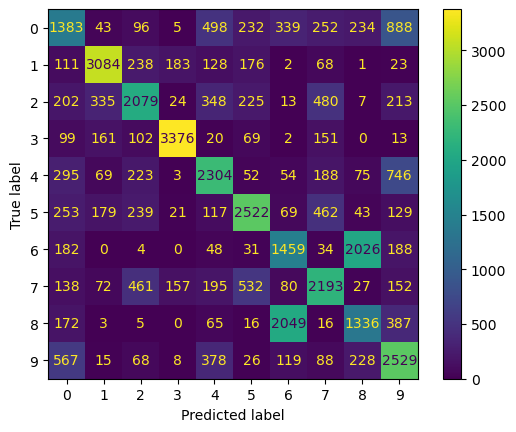

In [37]:
### Confusion Matrix for Random Forest Classifier model

train_y_pred = cross_val_predict(estimator = pipe4, X = train_X, y = train_y, cv = 5)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = train_y, y_pred = train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(train_y, train_y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()